# COMP 352 Final Project - Banana Quality

**Authors:** Precee Ginigeme, Kieran Kennedy, Evan Scott

**Date:** 12/17/2024

### Banana Quality Dataset

#### Full dataset: https://www.kaggle.com/datasets/mrmars1010/banana-quality-dataset

The Banana Quality Dataset includes comprehensive attributes of bananas categorized into quality classes such as "Good," "Unripe," and "Overripe." Key features encompass measurements like size, weight, color indicators, firmness, and other relevant parameters that influence banana quality. Analyzing the data can help reduce food waste, enhance supply chain efficiency, and improve consumer satisfaction by enabling accurate quality classification. 

## Table of Contents:
* [Data Importing and Pre-processing](#data-importing)
* [Data Analysis and Visualization](#data-vis)
* [Data Analytics](#data-analytics)

## Data Importing and Pre-processing <a class="anchor" id="data-importing"></a>

- Import dataset and describe characteristics such as dimensions, data types, file types, and import methods used
- Clean, wrangle, and handle missing data
- Encode any categorical variables
- Perform feature engineering on the dataset
- Transform data appropriately using techniques such as aggregation, normalization, and feature construction
- Reduce redundant data and perform need based discretization

- Imports

In [401]:
#importing libraries needed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

from sklearn.inspection import permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay

from pandas.plotting import scatter_matrix

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif


In [402]:
#read in file
banana_df = pd.read_csv("banana_quality_dataset.csv")

- Describing information about the dataset

In [403]:
#information about the dataset

print(f"Shape of Banana Dataset (rows, cols): {banana_df.shape} ")

# count the number of categorical variables
cat_count = 0
for dtype in banana_df.dtypes:
    if dtype == "object":
        cat_count = cat_count + 1


print("Number of categorical variables:", cat_count)

numeric_vars = banana_df.shape[1] - cat_count - 1
print(
    "Number of continuous variables:", numeric_vars
)  # subtract and extra column because one of the columns is an ID column


Shape of Banana Dataset (rows, cols): (1000, 16) 
Number of categorical variables: 5
Number of continuous variables: 10


In [404]:
banana_df.head()

,sample_id,variety,region,quality_score,quality_category,ripeness_index,ripeness_category,sugar_content_brix,firmness_kgf,length_cm,weight_g,harvest_date,tree_age_years,altitude_m,rainfall_mm,soil_nitrogen_ppm
0,1,Manzano,Colombia,1.88,Processing,2.11,Turning,16.83,3.53,21.44,146.92,2023-10-16,13.7,58.2,2440.5,183.6
1,2,Plantain,Guatemala,2.42,Processing,4.25,Ripe,16.73,4.09,26.11,160.48,2023-10-14,5.1,280.2,2374.6,109.8
2,3,Burro,Ecuador,3.57,Premium,6.24,Overripe,21.34,1.63,25.20,225.27,2023-09-08,17.7,1246.9,1191.5,147.7
3,4,Manzano,Ecuador,2.21,Processing,5.39,Ripe,16.75,3.31,13.08,137.80,2023-10-07,13.0,1150.2,2845.1,92.8
4,5,Red Dacca,Ecuador,2.35,Processing,5.84,Ripe,16.90,3.07,12.98,227.84,2023-10-02,4.8,526.0,2136.9,129.7


Dropping the quality_score column is necessary to avoid data leakage because the quality_category column, which is our target variable, appears to be a bucketed version of quality_score. Including quality_score as a feature in the model could lead to unrealistic predictions, as it directly informs the model about the target variable, thereby contaminating the training process. This would result in an unfair advantage and would distort the model's performance. Additionally, removing duplicates and redundant columns is an essential part of the data cleaning process, ensuring that the model is trained on meaningful and non-repetitive information, improving both efficiency and accuracy.

In [405]:
#Dropping "Quality Score" column to avoid data leakage

banana_df = banana_df.drop(columns=["quality_score"])
banana_df.head()

,sample_id,variety,region,quality_category,ripeness_index,ripeness_category,sugar_content_brix,firmness_kgf,length_cm,weight_g,harvest_date,tree_age_years,altitude_m,rainfall_mm,soil_nitrogen_ppm
0,1,Manzano,Colombia,Processing,2.11,Turning,16.83,3.53,21.44,146.92,2023-10-16,13.7,58.2,2440.5,183.6
1,2,Plantain,Guatemala,Processing,4.25,Ripe,16.73,4.09,26.11,160.48,2023-10-14,5.1,280.2,2374.6,109.8
2,3,Burro,Ecuador,Premium,6.24,Overripe,21.34,1.63,25.20,225.27,2023-09-08,17.7,1246.9,1191.5,147.7
3,4,Manzano,Ecuador,Processing,5.39,Ripe,16.75,3.31,13.08,137.80,2023-10-07,13.0,1150.2,2845.1,92.8
4,5,Red Dacca,Ecuador,Processing,5.84,Ripe,16.90,3.07,12.98,227.84,2023-10-02,4.8,526.0,2136.9,129.7


In [406]:
#amount of missing values in the dataset
total = banana_df.isnull().sum().sort_values(ascending=False)
percent = (banana_df.isnull().sum() / banana_df.isnull().count()).sort_values(
    ascending=False
)
missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
missing_data.head(20)

,Total,Percent
sample_id,0,0.0
variety,0,0.0
region,0,0.0
quality_category,0,0.0
ripeness_index,0,0.0
ripeness_category,0,0.0
sugar_content_brix,0,0.0
firmness_kgf,0,0.0
length_cm,0,0.0
weight_g,0,0.0


Upon inspection of the dataset, it was confirmed that there are no null or missing values present across any of the columns. This means that the dataset is already complete and there is no need for null imputation, a crucial step often required in data preprocessing when handling missing or incomplete data. Since this dataset is fully populated, we can proceed without concern for introducing bias or inaccuracies through imputation methods. The absence of null values simplifies the preprocessing pipeline and ensures that our model training will be based on complete, clean data.

Encoding the categorical varaibles

In [407]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()
cleaned_banana_df = banana_df.copy() #Making a copy to encode data and give to models

# Encode the 'quality_category' column, our target variable
cleaned_banana_df['quality_category'] = label_encoder.fit_transform(banana_df['quality_category'])


In [408]:
# Label encoding for 'ripeness_category'
cleaned_banana_df['ripeness_category'] = label_encoder.fit_transform(banana_df['ripeness_category'])

# Label encoding for 'region'
cleaned_banana_df['region'] = label_encoder.fit_transform(banana_df['region'])

# Label encoding for 'date' (extracting year, month, and day)
# Convert 'date' to datetime
cleaned_banana_df['harvest_date'] = pd.to_datetime(banana_df['harvest_date'])

# Label encoding for 'variety'
cleaned_banana_df['variety'] = label_encoder.fit_transform(banana_df['variety'])

# Check the changes in the dataframe
cleaned_banana_df.head()

,sample_id,variety,region,quality_category,ripeness_index,ripeness_category,sugar_content_brix,firmness_kgf,length_cm,weight_g,harvest_date,tree_age_years,altitude_m,rainfall_mm,soil_nitrogen_ppm
0,1,5,1,2,2.11,3,16.83,3.53,21.44,146.92,2023-10-16,13.7,58.2,2440.5,183.6
1,2,6,4,2,4.25,2,16.73,4.09,26.11,160.48,2023-10-14,5.1,280.2,2374.6,109.8
2,3,1,3,1,6.24,1,21.34,1.63,25.20,225.27,2023-09-08,17.7,1246.9,1191.5,147.7
3,4,5,3,2,5.39,2,16.75,3.31,13.08,137.80,2023-10-07,13.0,1150.2,2845.1,92.8
4,5,7,3,2,5.84,2,16.90,3.07,12.98,227.84,2023-10-02,4.8,526.0,2136.9,129.7



Label encoding was particularly beneficial for this specific dataset because it allowed us to convert the categorical variables into a format that could be effectively used by machine learning algorithms. For the ripeness_category, region, and variety columns, these features represent non-numeric, discrete categories that are essential for predicting the quality of bananas. Label encoding ensures that each unique category is mapped to a specific numeric value, making it easier for the model to process and learn from these features.

For example, the ripeness_category has an inherent order ("Turning" < "Ripe" < "Overripe"), making label encoding a natural fit as it preserves the ordinal relationship between categories. Similarly, the region and variety columns, are transformed into numeric values, which allows the model to capture any patterns or associations in these categorical features.

The harvest_date column, which represents the time a banana was harvested, was converted to a datetime type to facilitate the extraction of time-based features (year, month, day). This is particularly useful for a dataset like this, where time might have an impact on banana quality (e.g., seasonal variations). By extracting these temporal components, we can more effectively model and understand the influence of time on banana quality.

Overall, label encoding and datetime conversion were effective choices for this dataset because they transformed categorical and time-based features into formats suitable for predictive modeling, improving the ability to identify patterns in the data

In [409]:
# now recount the number of categorical variables
cat_count = 0
for dtype in cleaned_banana_df.dtypes:
    if dtype == "object":
        cat_count = cat_count + 1


print("After encoding, Number of categorical variables:", cat_count)

After encoding, Number of categorical variables: 0


Since we are working on a classification problem with the target variable being quality_category, normalization of the target variable is not necessary. The quality_category is a categorical variable, and normalization is typically applied to continuous numerical features to ensure they are on a similar scale.

Removing outliers in a classification problem is not always necessary and should only be considered if they significantly affect the model’s performance. Some outliers may represent natural variations in the population, and removing them could result in losing valuable information. Therefore, we elected to not remove any outliers before evaluating the model's performance.

In [410]:
cleaned_banana_df.head()

,sample_id,variety,region,quality_category,ripeness_index,ripeness_category,sugar_content_brix,firmness_kgf,length_cm,weight_g,harvest_date,tree_age_years,altitude_m,rainfall_mm,soil_nitrogen_ppm
0,1,5,1,2,2.11,3,16.83,3.53,21.44,146.92,2023-10-16,13.7,58.2,2440.5,183.6
1,2,6,4,2,4.25,2,16.73,4.09,26.11,160.48,2023-10-14,5.1,280.2,2374.6,109.8
2,3,1,3,1,6.24,1,21.34,1.63,25.20,225.27,2023-09-08,17.7,1246.9,1191.5,147.7
3,4,5,3,2,5.39,2,16.75,3.31,13.08,137.80,2023-10-07,13.0,1150.2,2845.1,92.8
4,5,7,3,2,5.84,2,16.90,3.07,12.98,227.84,2023-10-02,4.8,526.0,2136.9,129.7


## Data Analysis and Visualization <a class="anchor" id="data-vis"></a>

- Identify categorical, ordinal, and numerical variables within data
- Provide measures of centrality and distribution with visualizations
- Diagnose for correlations between variables and determine independent and dependent variables
- Perform exploratory analysis in combination with visualization techniques to discover patterns and features of interest
- Create visualizations that allow for the discovery of insights in the data

**Categorical Varialbes:** quality_Category, variety, region, ripeness_category

**Ordinal Variables:** quality_category(Processing < Good < Premium) ripeness_category(Turning < Ripe < Overripe)

**Numerical Variables:** ripeness_index, sugar_content_brix, firmness_kgf, length_cm, weight_g, harvest_date, tree_age_years, altitude_m

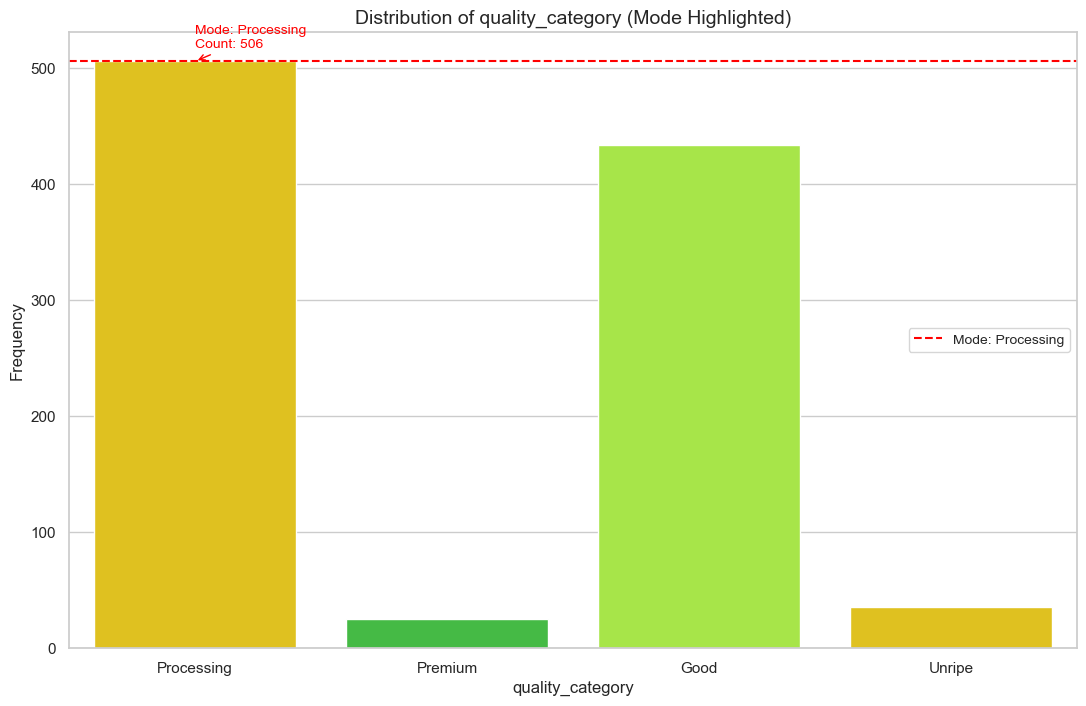

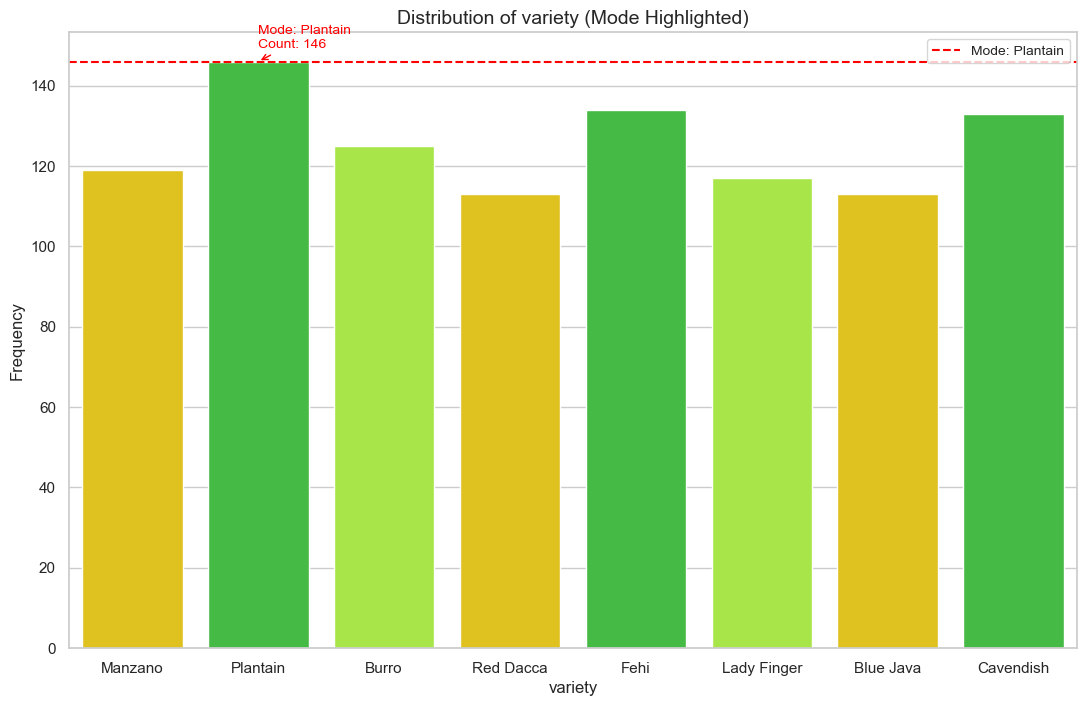

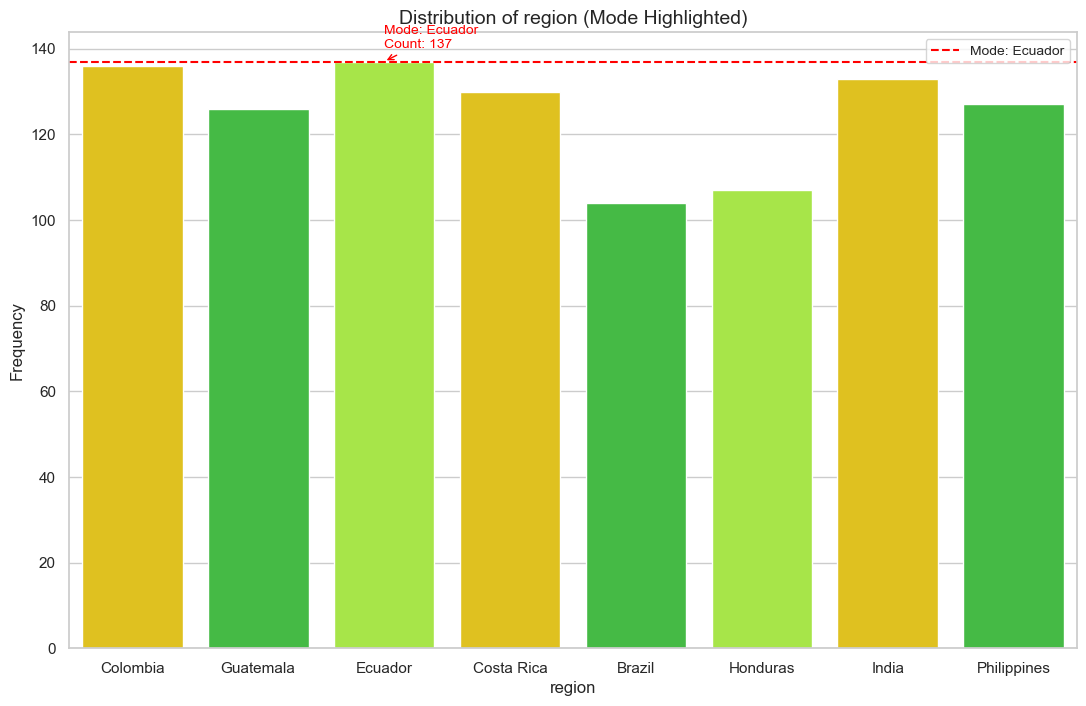

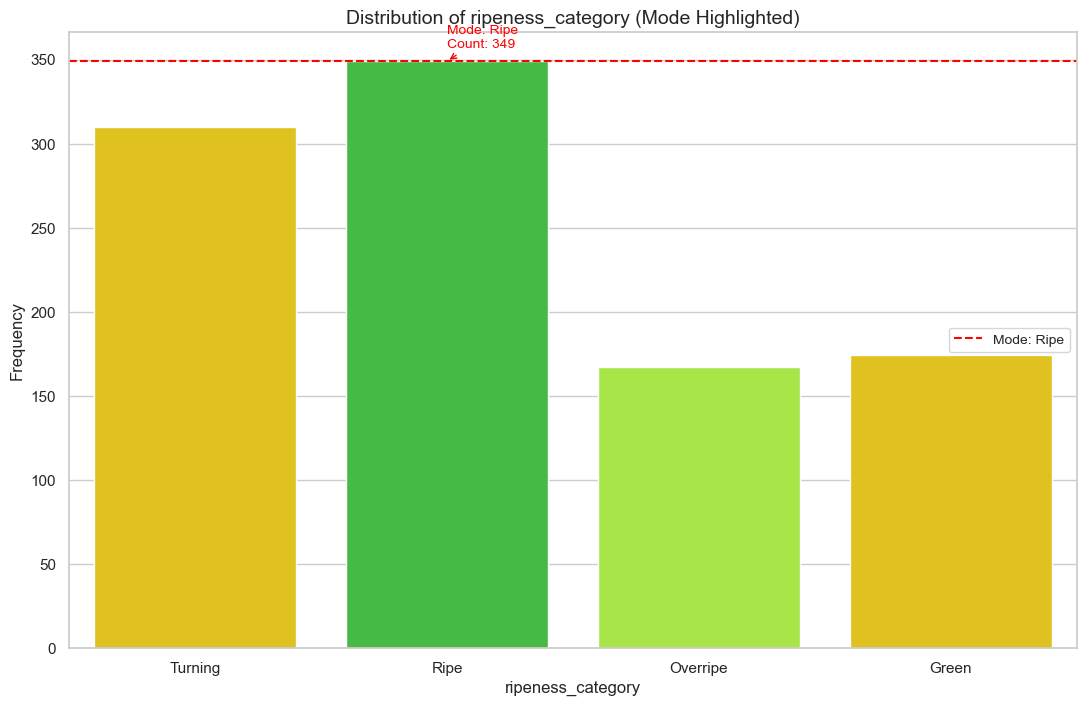

In [411]:
# Categorical Variables: Bar Plot with Mode Highlighted

sns.set_theme(style="whitegrid")
banana_colors = ["#FFD700", "#32CD32", "#ADFF2F"]

for col in ['quality_category', 'variety', 'region', 'ripeness_category']:
    mode_value = banana_df[col].mode()[0]
    plt.figure(figsize=(13, 8))
    sns.countplot(data=banana_df, x=col, palette=banana_colors)
    count = banana_df[col].value_counts()[mode_value]
    plt.axhline(count, color='red', linestyle='--', label=f'Mode: {mode_value}')
    plt.title(f'Distribution of {col} (Mode Highlighted)', fontsize=14)
    plt.xlabel(f"{col}", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.annotate(f"Mode: {mode_value}\nCount: {count}",
                 xy=(banana_df[col].value_counts().idxmax(), count), 
                 xytext=(0, 10), textcoords='offset points', 
                 arrowprops=dict(arrowstyle="->", color='red'),
                 color='red', fontsize=10)
    plt.show()



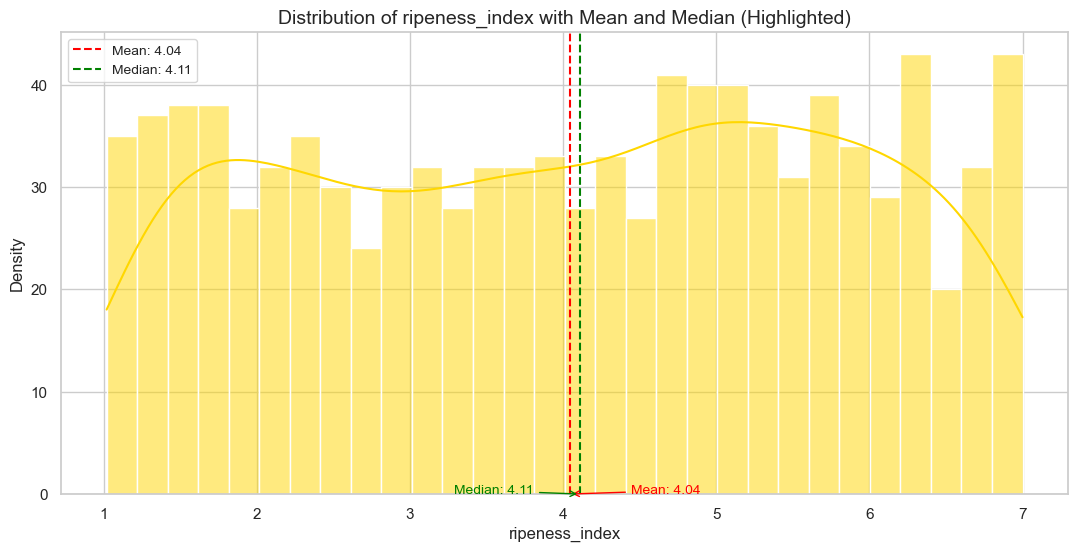

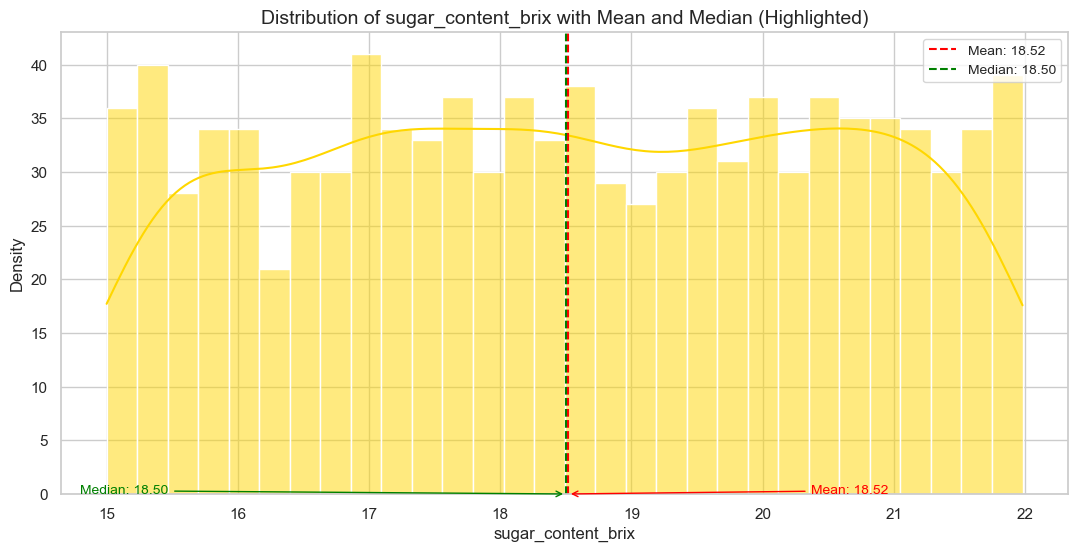

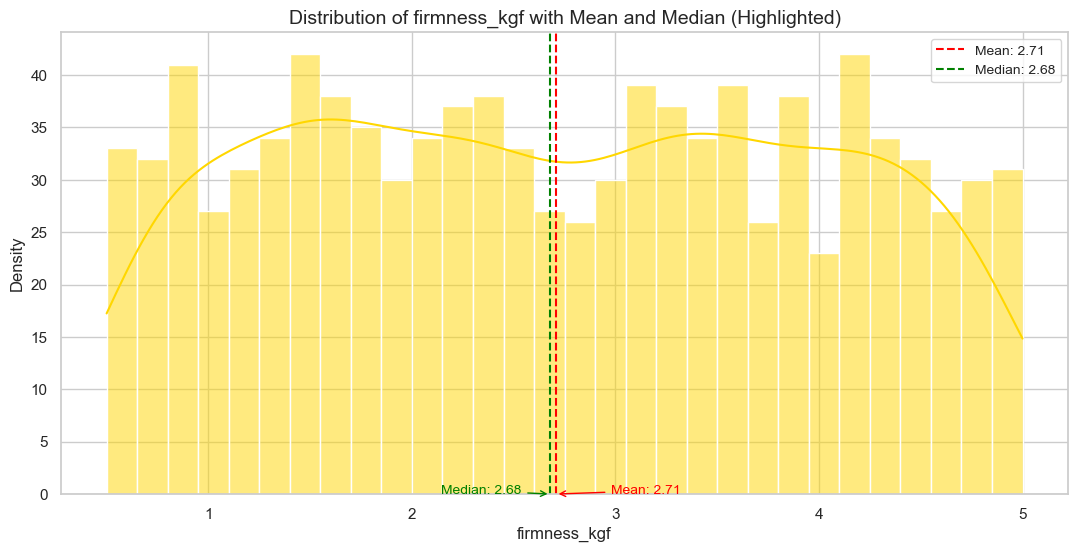

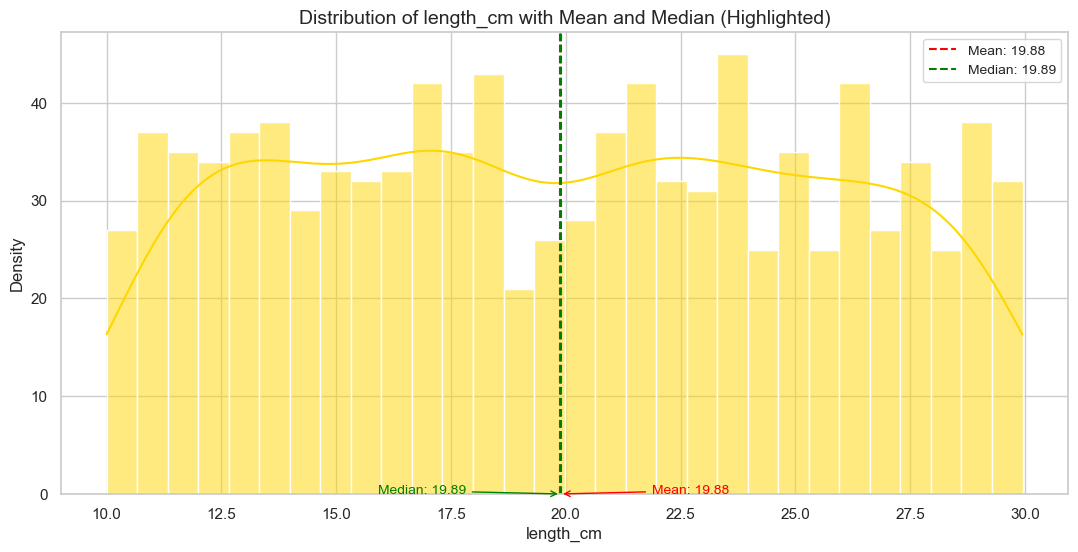

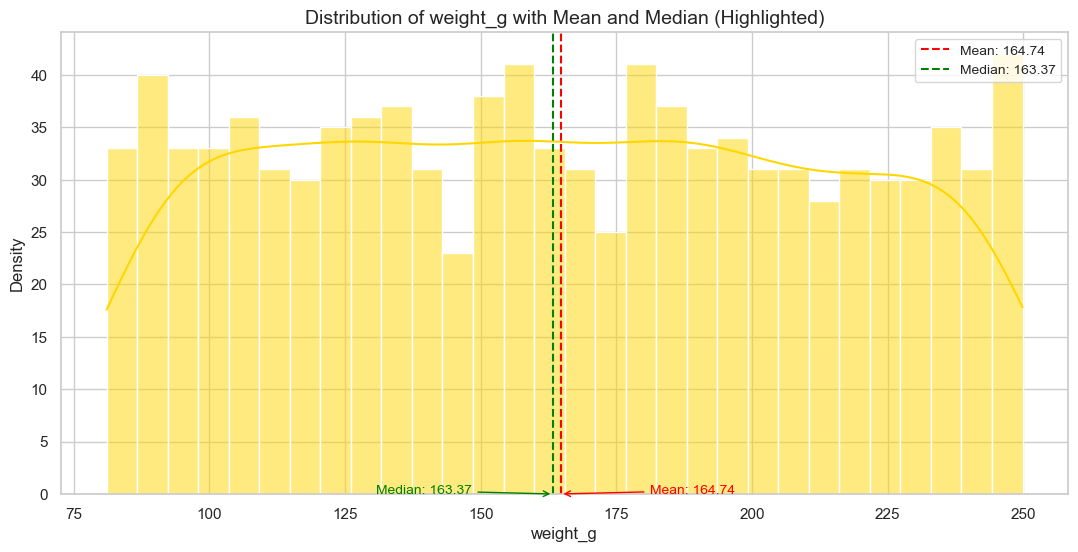

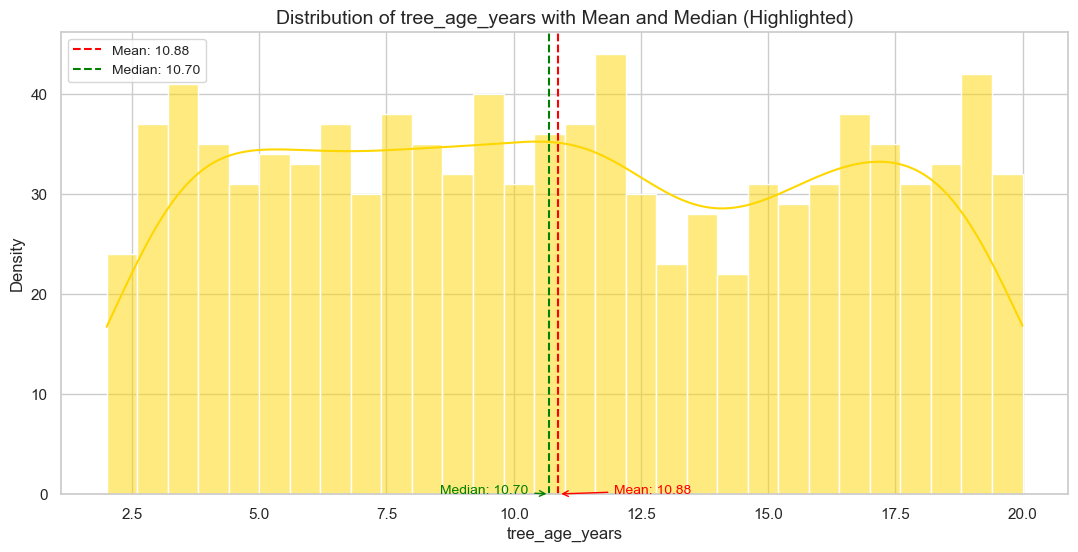

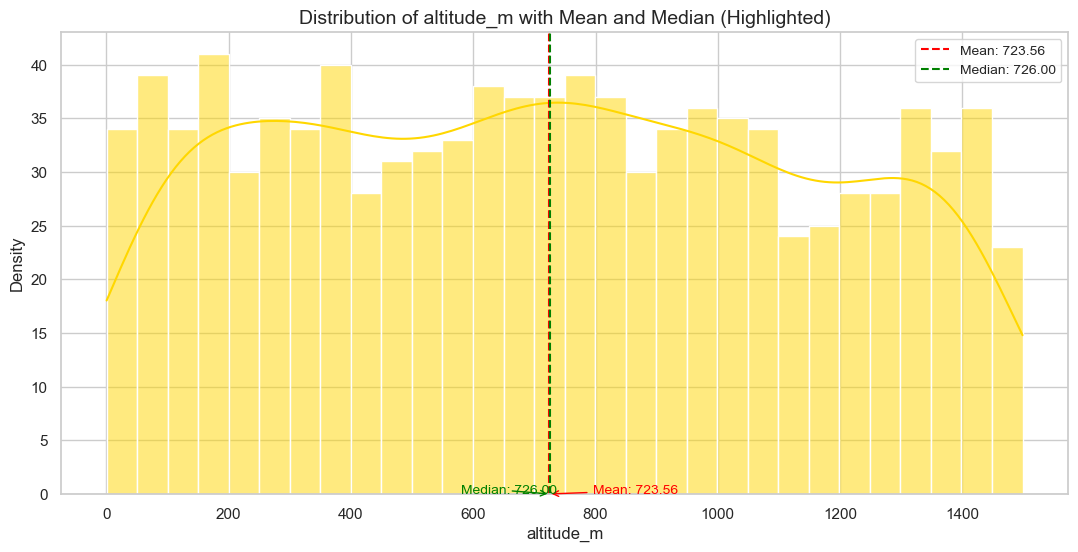

In [412]:
# Numerical Variables: Histogram with Annotated Mean and Median
num_vars = ['ripeness_index', 'sugar_content_brix', 'firmness_kgf', 'length_cm', 'weight_g', 'tree_age_years', 'altitude_m']
for col in num_vars:
    plt.figure(figsize=(13, 6))
    sns.histplot(banana_df[col], kde=True, bins=30, color='#FFD700')
    mean_val = banana_df[col].mean()
    median_val = banana_df[col].median()
    plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.2f}')
    plt.title(f'Distribution of {col} with Mean and Median (Highlighted)', fontsize=14)
    plt.xlabel(f"{col}", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.legend(fontsize=10)
    plt.annotate(f"Mean: {mean_val:.2f}", xy=(mean_val, 0), xytext=(mean_val + mean_val * 0.1, 0.02),
                 arrowprops=dict(arrowstyle="->", color='red'), color='red', fontsize=10)
    plt.annotate(f"Median: {median_val:.2f}", xy=(median_val, 0), xytext=(median_val - median_val * 0.2, 0.02),
                 arrowprops=dict(arrowstyle="->", color='green'), color='green', fontsize=10)
    plt.show()

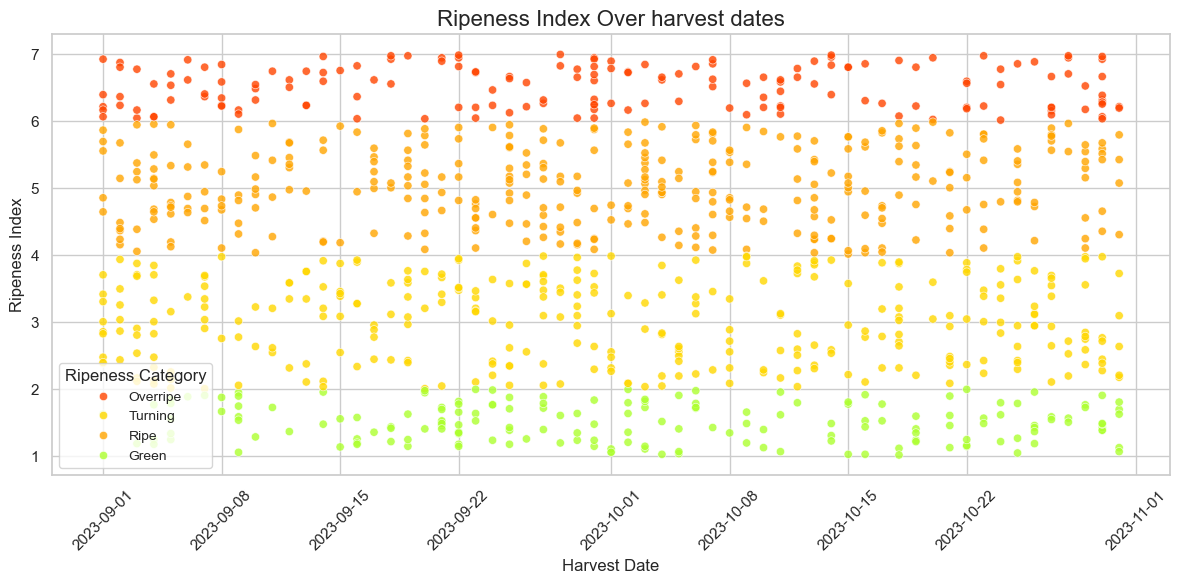

In [413]:
#Time series table for ripeness index over time of the harvest dates

banana_df['harvest_date'] = pd.to_datetime(banana_df['harvest_date'])

# Sort data by harvest_date
banana_df = banana_df.sort_values('harvest_date')

# Plot ripeness index over harvest date
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=banana_df,
    x='harvest_date',
    y='ripeness_index',
    hue='ripeness_category',
    palette={
        'Green': '#ADFF2F',
        'Turning': '#FFD700',
        'Ripe': '#FFA500',
        'Overripe': '#FF4500'
    },
    alpha=0.8,
    sizes=(50, 200),
    legend='full'
)
plt.title('Ripeness Index Over harvest dates', fontsize=16)
plt.xlabel('Harvest Date', fontsize=12)
plt.ylabel('Ripeness Index', fontsize=12)
plt.legend(title='Ripeness Category', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



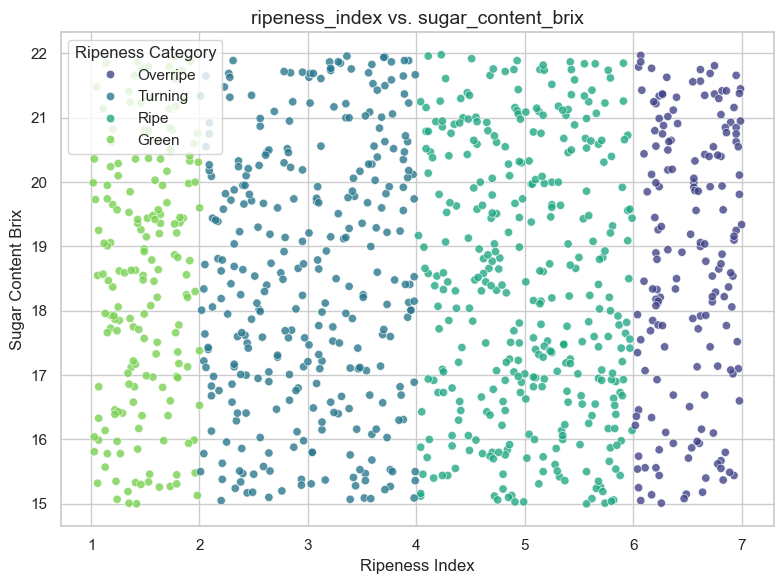

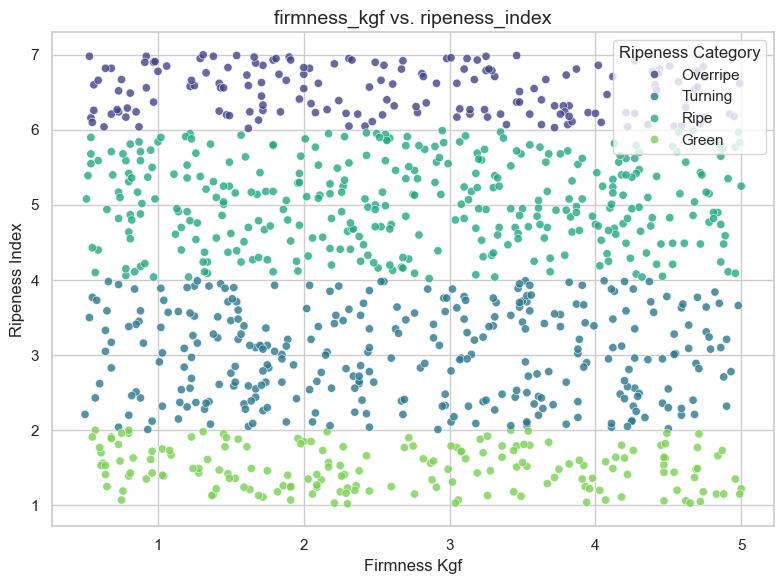

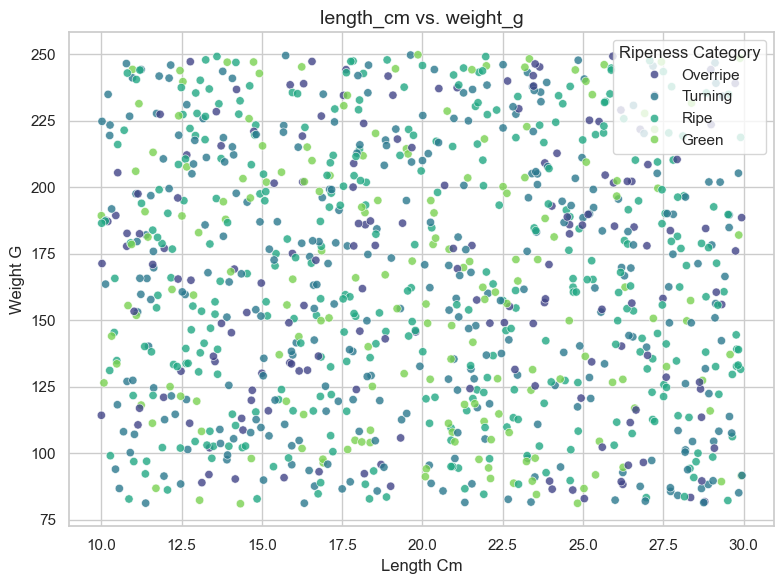

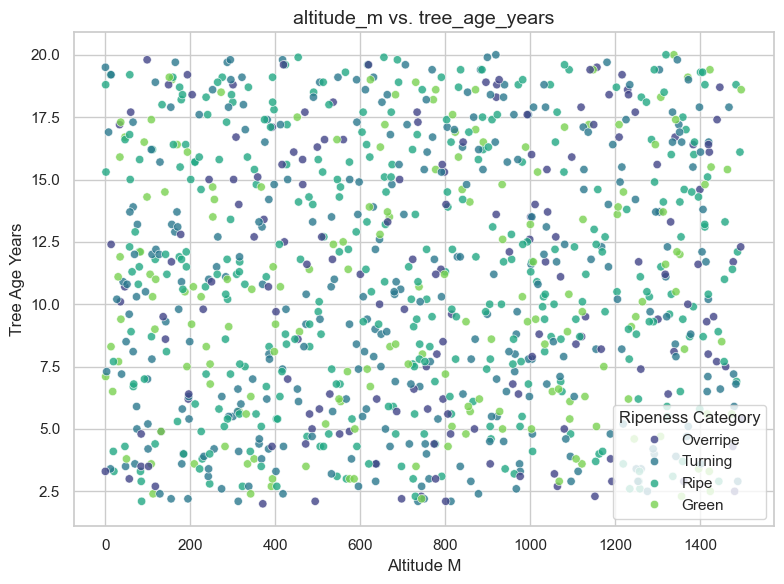

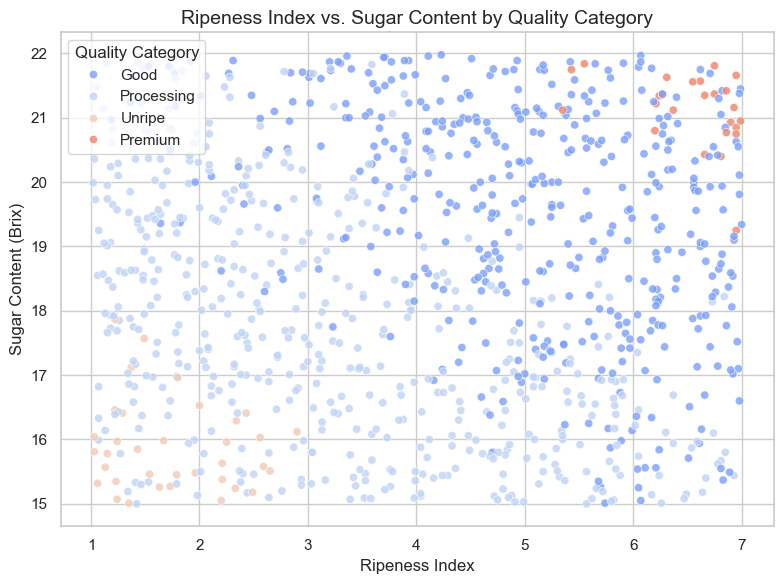

In [414]:
import matplotlib.pyplot as plt
import seaborn as sns

# Numerical variable scatterplots
numerical_pairs = [
    ('ripeness_index', 'sugar_content_brix'),
    ('firmness_kgf', 'ripeness_index'),
    ('length_cm', 'weight_g'),
    ('altitude_m', 'tree_age_years')
]

for x, y in numerical_pairs:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=banana_df, x=x, y=y, hue='ripeness_category', palette='viridis', alpha=0.8)
    plt.title(f'{x} vs. {y}', fontsize=14)
    plt.xlabel(x.replace('_', ' ').title(), fontsize=12)
    plt.ylabel(y.replace('_', ' ').title(), fontsize=12)
    plt.legend(title='Ripeness Category')
    plt.tight_layout()
    plt.show()

# Categorical influence on numerical scatterplots
plt.figure(figsize=(8, 6))
sns.scatterplot(data=banana_df, x='ripeness_index', y='sugar_content_brix', hue='quality_category', palette='coolwarm', alpha=0.8)
plt.title('Ripeness Index vs. Sugar Content by Quality Category', fontsize=14)
plt.xlabel('Ripeness Index', fontsize=12)
plt.ylabel('Sugar Content (Brix)', fontsize=12)
plt.legend(title='Quality Category')
plt.tight_layout()
plt.show()


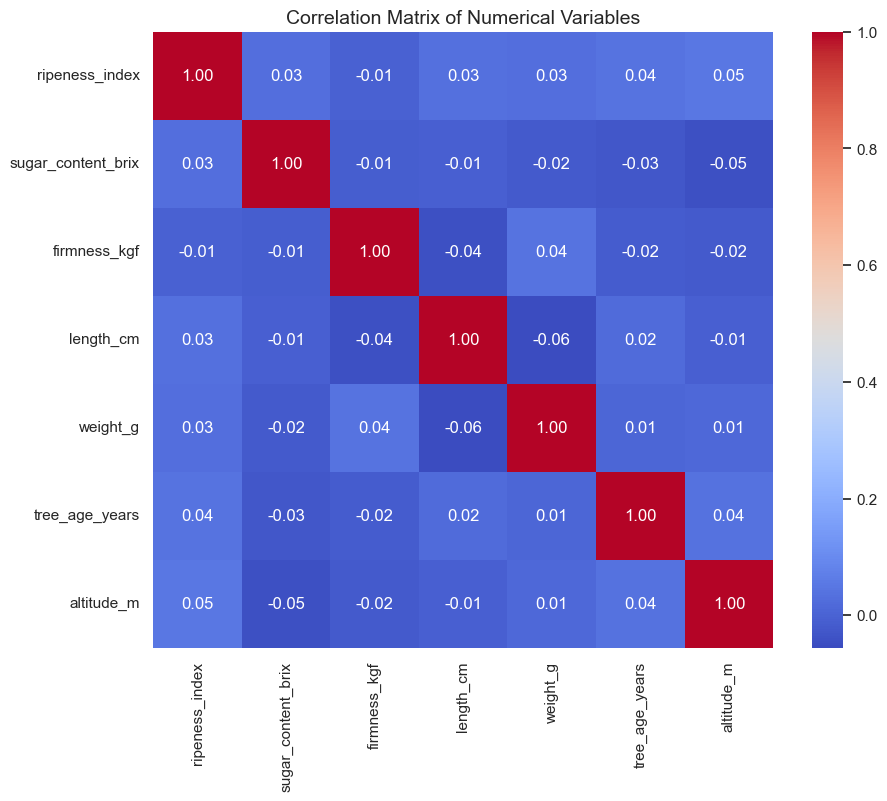

In [415]:
# Correlation matrix for numerical variables
numerical_vars = ['ripeness_index', 'sugar_content_brix', 'firmness_kgf', 'length_cm', 'weight_g', 'tree_age_years', 'altitude_m']
correlation_matrix = banana_df[numerical_vars].corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numerical Variables', fontsize=14)
plt.show()


In performing exploratory data analysis (EDA) for the banana dataset, a key insight emerges from the weak correlations between the numerical variables. The correlation coefficients between most pairs of numerical features are extremely low, none exceeding 0.06, which suggests that there is minimal linear relationship between these variables. This indicates that the features are largely independent of one another, or that non-linear relationships exist that are not captured by the Pearson correlation.

We performed density curve visualizations for each individual numerical variable, and in all cases, the mean and median were close to each other. This indicates minimal skewness, with no strong outliers significantly affecting the data. Additionally, the time series analysis of the harvest_date revealed that the majority of bananas were categorized as either "ripe" or "turning," with "unripe" and "overripe" categories being much less common. This suggests that bananas are typically harvested at later stages of ripeness, and the harvest_date may play a role in determining the ripeness category adn quality category.

Given these observations, it’s clear that while the dataset may not show strong correlations between numerical variables, there are other patterns worth exploring. The weak correlations suggest that variables like ripeness_index, sugar_content_brix, and firmness_kgf may be somewhat independent of each other, but further analysis through other methods could help identify latent structures or groupings within the data.

## Data Analytics <a class="anchor" id="data-analytics"></a>

- Determine the need for a supervised or unsupervised learning method and identify dependent and independent variables
- Choose and provide reasoning for the selected metric or metrics employed to assess your model.
- Train, test, cross validate, and provide performance metrics for model results
- Try multiple different types of algorithms to determine the best model for your dataset
- Analyze your model performance